## Breakpoints

#### Revisão
Para aplicações com interação humana, muitas vezes queremos visualizar as saídas do nosso grafo enquanto ele está em execução.

Lançamos as bases para isso com o streaming.

#### Objetivos
Agora, vamos falar sobre as motivações para a interação humana:

(1) Aprovação - Podemos interromper nosso agente, exibir o estado para um usuário e permitir que ele aceite uma ação.

(2) Depuração - Podemos retroceder o grafo para reproduzir ou evitar problemas.

(3) Edição - Você pode modificar o estado.

O LangGraph oferece diversas maneiras de obter ou atualizar o estado do agente para suportar vários fluxos de trabalho com interação humana.

### Breakpoints para aprovação humana

Neste exemplo nós iremos simular uma preocupação com o uso das tools.

Nós queremos aprovar o agente para usar qualquer uma das tools.

Tudo o que precisamos fazer é compilar o grapho com `interrupt_before=["tools"]` onde tools é o nosso nó de tools.

Isso significa que a execução será interrompida antes do nó de tools, que executa a chamada dos tools.

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b,
    Args:
        a: first int
        b: second int
    """

    return a * b

def add(a: int, b: int) -> int:
    """Add a ansd b,

    Args:
        a: first int
        b: second int
    """

    return a + b

def divide(a: int, b: int)-> int:
    """Devide a and b

    Args:
        a: first int
        b: second int 
    
    """

    return a / b

tools=[multiply, add, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
system_message= SystemMessage(content= "You are a helpful assistant tasked with performing arithmectic on a set of inputs")

def assistant(state: MessageState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

builder= StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

A diferença entre o `llm.bind_tools(tools)` e o `ToolNode(tools)` é a separação de responsabilidades entre Raciocínio/Decisão e Ação/Execução.

Ambos são essenciais, mas servem a propósitos completamente distintos no ciclo de ReAct (Reasoning and Acting).

#### 🧠 1. llm.bind_tools(tools): Habilidade e Decisão
O método llm.bind_tools(tools) é uma funcionalidade da LangChain Core que integra o metadado das funções ao modelo de linguagem (LLM).

* O que Faz: Ele transforma o objeto llm em llm_with_tools. Internamente, ele anexa as assinaturas das suas funções Python (incluindo nomes, parâmetros e docstrings) ao payload enviado para a API da OpenAI.

* Propósito: Dar ao modelo a capacidade de raciocínio. A LLM (GPT-4o) usa essa informação para decidir se a solicitação do usuário deve ser respondida com texto ou com uma instrução de chamada de ferramenta (ToolCall).

* Resultado: Se o modelo decidir usar uma ferramenta (ex: para calcular 2 + 3), ele não gera a resposta final em texto. Em vez disso, ele retorna um objeto AIMessage que contém uma instrução de chamada de ferramenta (ToolCall) com os argumentos necessários.

É a camada de Inteligência e Raciocínio.

#### ⚙️ 2. ToolNode(tools): Execução e Ação
O ToolNode(tools) é um componente específico do LangGraph que é adicionado ao grafo como um nó.

* O que Faz: Ele recebe a instrução de chamada de ferramenta (ToolCall) gerada pela LLM e executa o código Python real (suas funções multiply, add, divide) localmente no seu ambiente.

* Propósito: Gerenciar a ação e o runtime. Ele é responsável por:

    1. Receber o ToolCall do nó "assistant".

    2. Executar a função correspondente (multiply(2, 3)).

    3. Capturar o resultado (ex: 6).

    4. Empacotar esse resultado em uma ToolMessage e anexá-la ao estado do grafo.

É a camada de Ação e Execução do Código.

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

Quando invocamos o grafo com None, ele simplesmente continuará a partir do último ponto de verificação de estado!

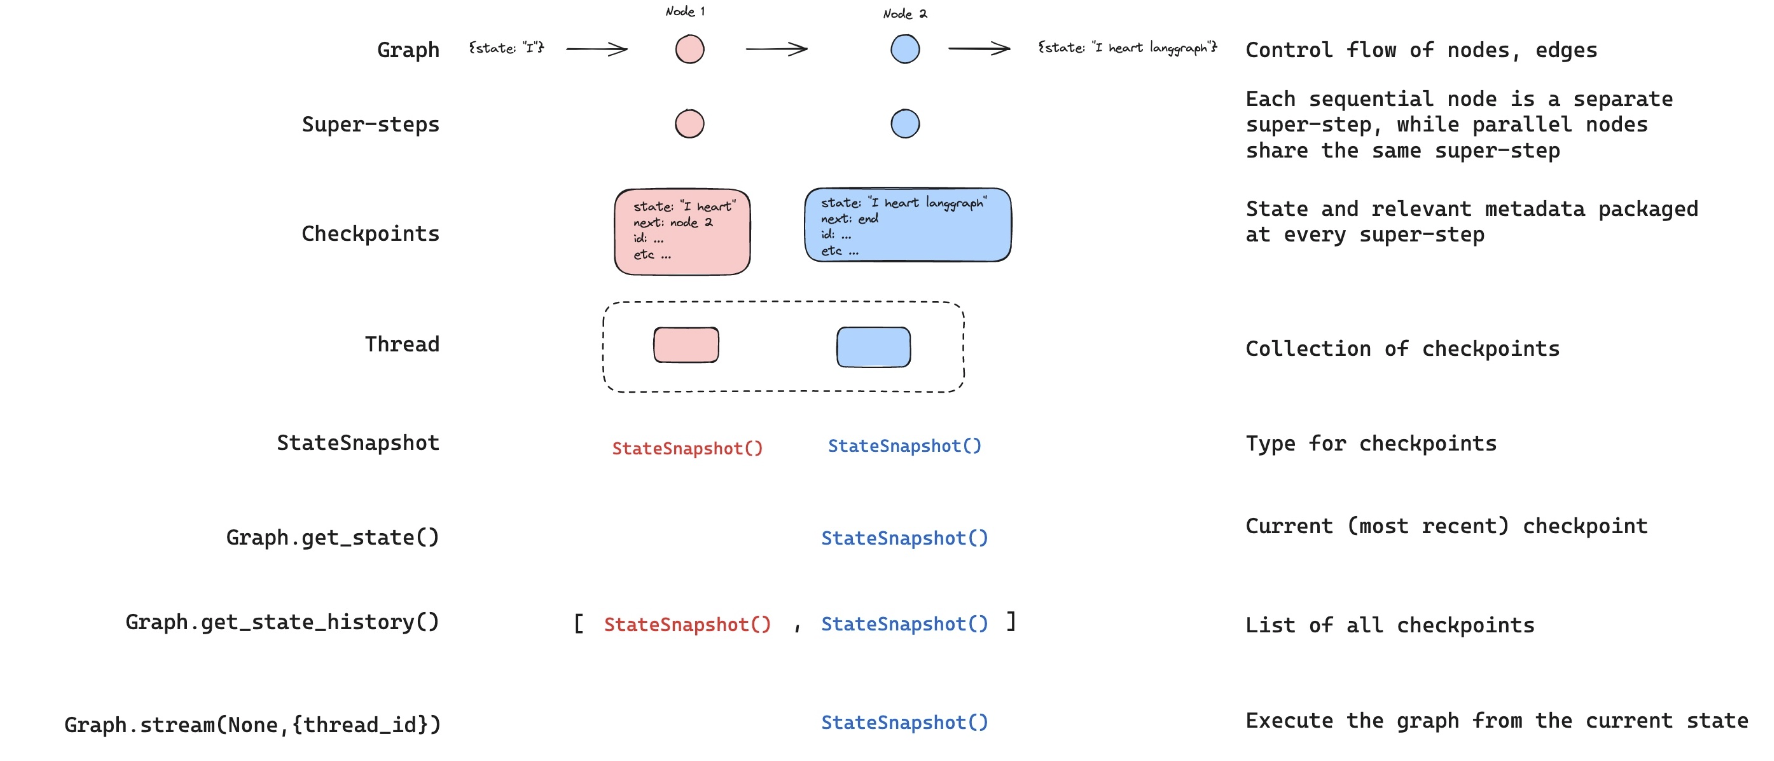

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

### Breakpoints with LangGraph API

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

Como mostrado acima, podemos adicionar `interrupt_before=["node"]` ao compilar o grafo que está sendo executado no Studio.

No entanto, com a API, você também pode passar `interrupt_before` diretamente para o método de fluxo.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Agora, podemos prosseguir a partir do ponto de interrupção da mesma forma que fizemos antes, passando o thread_id e None como entrada!

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)